# Edit an NDEx network using networkx and save a new copy

In this tutorial we will:
- download a network from NDEx as a NiceCX network
- make a networkx `Graph()` object via the `to_networkx(mode='default')` method
- display the networkx network
- remove 0 degree nodes
- create a new NiceCX network from the modified networkx network
- uploading the new network to NDEx. 

This tutorial requires Python 3.7+ and networkx 2.4+

# Import modules

Import needed modules. If there is an error with matplotlib run:

`conda install -c conda-forge matplotlib`

**NOTE:** For better support for Anaconda environments, exit Jupyter and run:
          `conda install -c anaconda nb_conda`

In [1]:
import matplotlib

# If notebook crashes or gives matplotlib error try uncommenting the next line 
# matplotlib.use('Qt4Agg')
# this matplotlib inline enables the matplotlib plots to be displayed in the Jupyter notebook
%matplotlib inline

import matplotlib.pyplot as plt
import ndex2
import networkx

# used to prompt user for NDEx password in this notebook
import getpass


# Download the example network from NDEx

Using the `create_nice_cx_from_server()` the following line of code downloads the network from NDEx and creates a `NiceCXNetwork` object named `nice_cx_network`. 

For help on function names try running `help(nice_cx_network)`

In [2]:
# EXAMPLE NETWORK FROM NDEx CIViC Variant-Drug Associations
# Viewable in a browser here: https://www.ndexbio.org/index.html#/network/58b909ff-d961-11ed-b4a3-005056ae23aa
civic_variant_drug_network_uuid = '58b909ff-d961-11ed-b4a3-005056ae23aa'

nice_cx_network = ndex2.create_nice_cx_from_server('public.ndexbio.org', 
                                                   uuid=civic_variant_drug_network_uuid)

# Make a networkx graph from the NiceCXNetwork

This fragment of code uses `to_networkx(mode='default')` to make a networkx `Graph()` object. 

In [3]:

g = nice_cx_network.to_networkx(mode='default')

print('NiceCXNetwork number of nodes: ' + str(len(nice_cx_network.get_nodes())) + 
      ' vs Networkx: ' + str(len(list(g))))
print('NiceCXNetwork number of edges: ' + str(len(nice_cx_network.get_edges())) +
      ' vs Networkx: ' + str(g.number_of_edges()))

# the networkx object has the name and description of the original network
if g.graph.get('name'):
   print(g.graph)

NiceCXNetwork number of nodes: 2249 vs Networkx: 2249
NiceCXNetwork number of edges: 2490 vs Networkx: 2490
{'name': 'CIViC Variant-Drug Associations', 'description': 'Obtained using Clinical Evidence Summaries. This is a subset of the complete data set as not all variants are linked to drug info.??<div><br/></div><div>Legend:<div>- Drug node = light green diamond</div><div>- Variant node = short rectangle</div><div>- Edge colors map to &#34;evidence_level&#34; (A through E) and match the CIViC color code.</div><div>- Edge thickness maps to &#34;rating&#34; (thinner = 1, thicker = 5)</div></div>', 'version': '2023-01-10', '@context': '{"CIViC gene": "https://civic.genome.wustl.edu/links/genes/", "CIViC variant": "https://civic.genome.wustl.edu/links/variants/", "CIViC evidence": "https://civic.genome.wustl.edu/links/evidence_items/", "DOID": "https://identifiers.org/doid/DOID:", "PMID": "https://identifiers.org/pubmed/", "Ensembl Transcript": "https://identifiers.org/ensembl/", "Entrez

# Plot your network in the notebook

If the following fails, the issue might be due to installation of older version of networkx (1.11) 

To fix this, exit jupyter and run the following in the terminal:

`pip install networkx --upgrade`

Then restart jupyter notebook (ie `jupyter notebook`) 

networkx version: 3.1
starting...


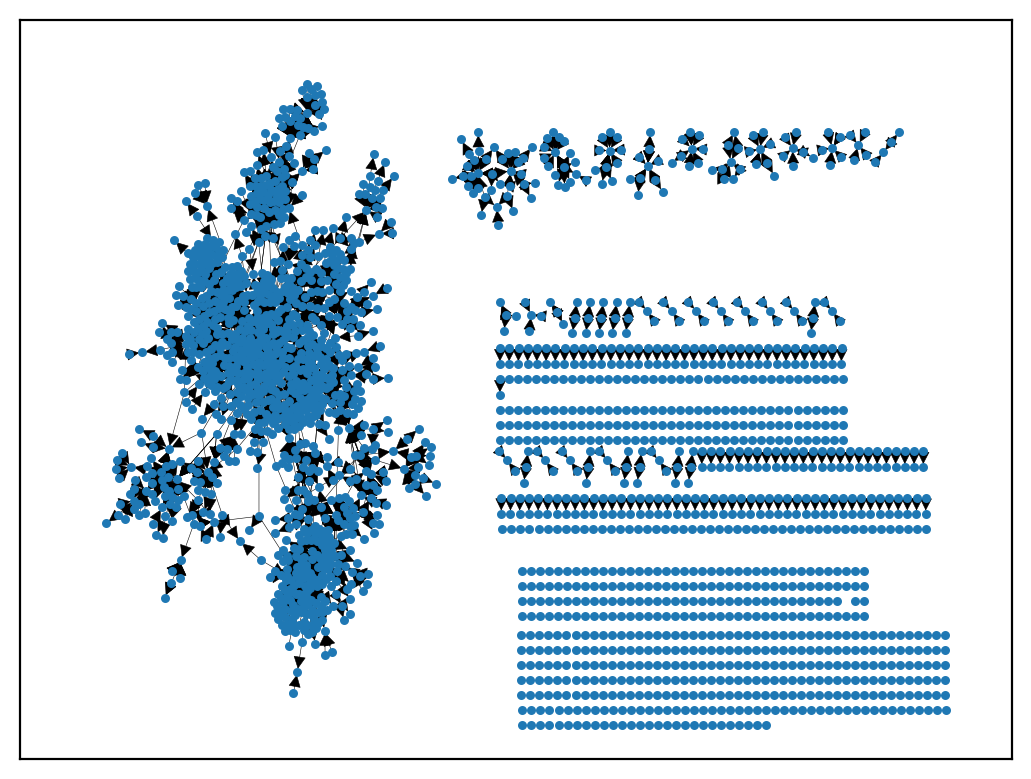

In [4]:
print("networkx version: " + networkx.__version__)
print("starting...")
plt.rcParams['figure.dpi'] = 200
networkx.draw_networkx(g, pos=g.pos, node_size=5, with_labels=False, width=0.2)

# Get a list of the zero degree nodes

We use the networkx method `isolates()` to get a list of all zero degree nodes and then store them in the variable `isolatelist`

In [5]:
isolatelist = list(networkx.isolates(g))
print('Number of zero degree nodes: ' + str(len(isolatelist)))

Number of zero degree nodes: 675


# Remove the zero degree nodes and their positions

We will now remove the zero degree nodes by their ids on the `isolatelist`

We also need to remove the node _positions_ of the removed nodes because networkx doesn't do this automatically. If the positions of deleted nodes are not removed the network will be flagged as invalid when it is written to NDEx.

In [6]:
print('Number of nodes before removal: ' + str(len(list(g))))
# the nodes in the networkx graph are the node ids from the NiceCX network

g.remove_nodes_from(isolatelist)

# we will now remove the node positions of the removed nodes from g.pos 
new_pos = {}
for node_id, coordinate in g.pos.items():
    if node_id not in isolatelist:
        new_pos[node_id] = coordinate

g.pos = new_pos

print('Number of nodes after removal: ' + str(len(list(g))))
print('Number of node positions after removal ', len(g.pos))

Number of nodes before removal: 2249
Number of nodes after removal: 1574
Number of node positions after removal  1574


# Convert the networkx object back to a NiceCXNetwork object

The following code converts the networkx graph object `g` back to a 
`NiceCXNetwork` object using `create_nice_cx_from_networkx()`

Additional calls below set the name of the network as well as the description. 

Finally, for debugging puposes, the number of nodes and edges is output for both objects

In [7]:
# we use the networkx object, g, to create a NiceCXNetwork object
newnetwork = ndex2.create_nice_cx_from_networkx(g)

# we demonstrate that the new NiceCXNetwork object has the same number of nodes and edges as the networkx object
print('NiceCXNetwork from networkx number of nodes: ' + str(len(newnetwork.get_nodes())) + 
      ' vs Networkx: ' + str(len(g)))
print('NiceCXNetwork from networkx number of edges: ' + str(len(newnetwork.get_edges())) +
      ' vs Networkx: ' + str(g.number_of_edges()))

# we will set the name of the new network to be a modification of the original network
newnetwork.set_name(nice_cx_network.get_name() + ' 0 degree nodes removed')

# and also set a description for the network
newnetwork.set_network_attribute('description', values='my network with 0 degree nodes removed')


NiceCXNetwork from networkx number of nodes: 1574 vs Networkx: 1574
NiceCXNetwork from networkx number of edges: 2490 vs Networkx: 2490


# Handle errors in conversion from networkx to CX
There are a couple bugs in `ndex2.create_nice_cx_from_networkx()` method. The big ones being
incorrect addition of node attributes `represents` and `name` The other ones involve incorrectly
guessing data types of data. The code block below handles this in a naive way be converting
all data values to a string and the data type to string for ndoes and edge attributes.

**NOTE:** This occurs in versions of ndex2 client version 3.4.0 and earlier

In [8]:
for node_id, node_obj in newnetwork.get_nodes():
    newnetwork.remove_node_attribute(node_id, 'represents')
    newnetwork.remove_node_attribute(node_id, 'name')
    for n_attr in newnetwork.get_node_attributes(node_id):
        n_attr['v'] = str(n_attr['v'])
        n_attr['d'] = 'string'
        
for edge_id, edge_obj in newnetwork.get_edges():
    for e_attr in newnetwork.get_edge_attributes(edge_id):
        e_attr['d'] = 'string'
        e_attr['v'] = str(e_attr['v'])


# Enter your NDEx username 

Be sure to hit enter in the field to set the value!!

In [9]:
ndexuser = getpass.getpass()

········


# Enter your NDEx password 

Be sure to hit enter in the field to set the value!!

In [10]:
ndexpassword = getpass.getpass()

········


# Upload your network to NDEx

In [11]:
res = newnetwork.upload_to('www.ndexbio.org', ndexuser, ndexpassword)

print('URL returned by upload_to call: ' + res)
newnetwork_uuid = res.split('/')[-1]

print('Network UUID: ' + newnetwork_uuid)

Generating CX
URL returned by upload_to call: https://www.ndexbio.org/v2/network/31e53e1f-d97d-11ed-b4a3-005056ae23aa
Network UUID: 31e53e1f-d97d-11ed-b4a3-005056ae23aa


# Apply the style from the original network to your network

When converting to/from networkx Graph() the style on the original network is lost. To recover that style, we will use get the style from the original network using the `apply_template()` method. 
`apply_template()` retrieves the style from a network in NDEx and applies it to the current network. 

In [12]:
newnetwork.apply_template('public.ndexbio.org', civic_variant_drug_network_uuid)

# Update our network on NDEx

Rather then uploading an additional network to NDEx, we will update the one we just wrote using the `update_to()` method. This method requires the network's UUID as the first argument.

In [13]:
newnetwork.update_to(newnetwork_uuid, 'public.ndexbio.org', ndexuser, ndexpassword)

Generating CX


''